First five rows of the dataset:
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0

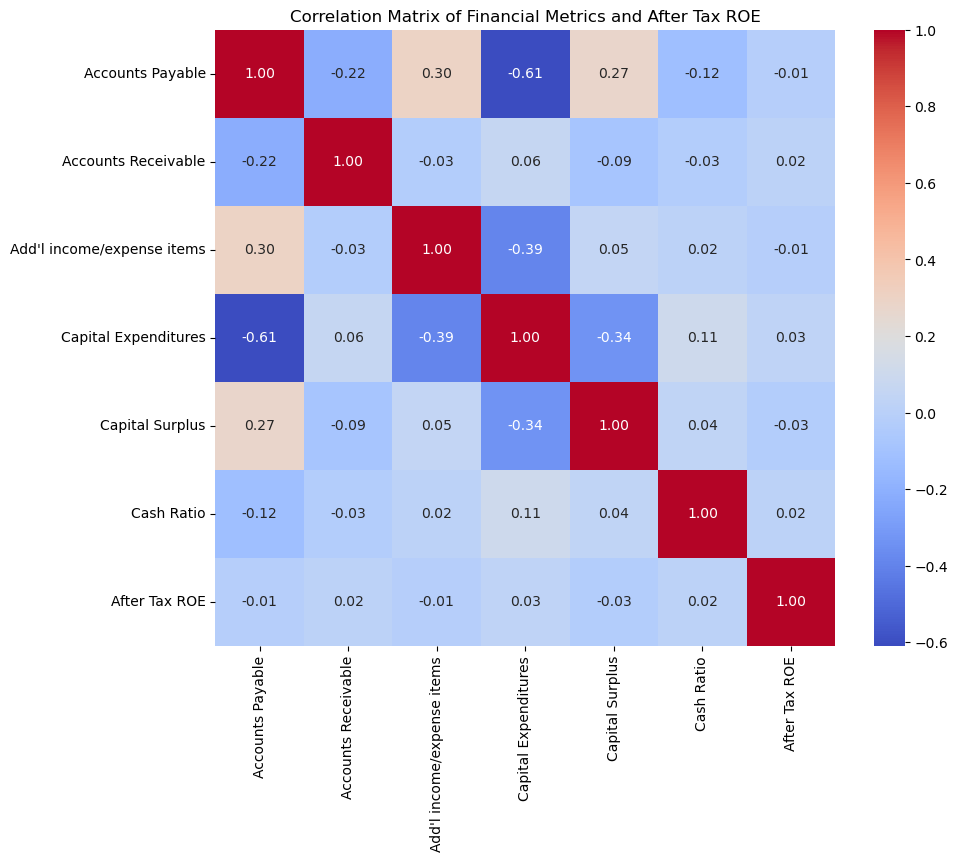

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../data/raw/fundamentals.csv')

# Display the first few rows to inspect the data
print("First five rows of the dataset:")
print(df.head())

# List all columns to identify the ones we need
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Define the columns we need (update the names based on your dataset)
columns_needed = [
    'Accounts Payable',
    'Accounts Receivable',
    "Add'l income/expense items",  # Corrected column name
    'Capital Expenditures',
    'Capital Surplus',
    'Cash Ratio',
    'After Tax ROE'  # This column exists in your dataset
]

# Check if these columns exist in the DataFrame
missing_columns = [col for col in columns_needed if col not in df.columns]
if missing_columns:
    print(f"\nThe following columns are missing from the dataset: {missing_columns}")
else:
    print("\nAll required columns are present.")

# Proceed only if all required columns are present
if not missing_columns:
    # Create a new DataFrame with the selected columns
    df_selected = df[columns_needed]

    # Handle missing values by dropping rows with any missing data
    df_selected = df_selected.dropna()

    # Display the first few rows of the selected data
    print("\nSelected data after dropping missing values:")
    print(df_selected.head())

    # Compute the correlation matrix
    corr_matrix = df_selected.corr()

    # Display the correlation matrix
    print("\nCorrelation matrix:")
    print(corr_matrix)

    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Financial Metrics and After Tax ROE')
    plt.show()
else:
    print("\nCannot proceed with missing columns. Please update the columns_needed list with correct column names.")
